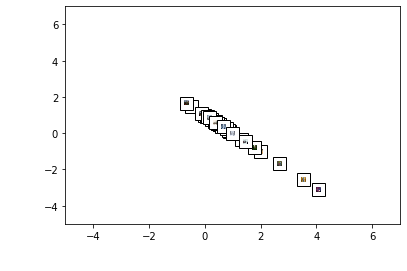

Run classifiers with initial size
1-NN Mean score:  0.6333333333333332
SVM Mean score:  0.7333333333333334
********************************************************************************
Run classifiers with pca size
1-NN Mean score:  0.5666666666666667
SVM Mean score:  0.6


In [32]:
import os

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib import offsetbox
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

size_100 = (100,100)
path = "images"

def loadImages(path):

    '''
    :param path: absolute path of images
    :return: 2 arrays. The first one is an numpy array of numpy arrays
    30 rows of (10000,3). 100*100 pixels each one described
    by a tuple of 3 values (r,g,b)
    The second one dimensional array contains the image labels
    '''
    listOfImages = []
    labels = []
    for imageFileName in os.listdir(path):
        image = Image.open(path+"/"+imageFileName)
        image = image.resize(size_100)
        '''
        we reshape every image to an 1d array with size 100*100.
        each row contains a tuple with (r,g,b) values
        '''
        listOfImages.append(np.reshape(image, (100*100,3)))
        if imageFileName.startswith('W'):
            labels.append(0)
        elif imageFileName.startswith('F'):
            labels.append(1)
        else:
            imageFileName.startswith('S')
            labels.append(2)
    return np.asarray(listOfImages),np.asarray(labels)

def PCA_ImageSpaceVisualization(images):
    listOfPCAComponents = []
    projectedImages = []

    for image in images:
        pca = PCA(2).fit(image)
        projectedImage = pca.transform(image)
        listOfPCAComponents.append(pca)
        projectedImages.append(projectedImage)

    centroids = []
    for projectedImage in projectedImages:
        centroids.append(centeroidnp(projectedImage))
    centroidsNormalized = normalize(centroids)

    fig, ax = plt.subplots()
    for n,projectedImage in enumerate(projectedImages):
        imagebox = OffsetImage(np.reshape(images[n], (100,100,3)), zoom=.05)
        imagebox.image.axes = ax
        ab = AnnotationBbox(imagebox,xy = centroidsNormalized[n])
        ax.add_artist(ab)
        ax.set_xlim(-5,7)
        ax.set_ylim(-5,7)
    plt.draw()
    plt.show()
    return projectedImages

def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

def normalize(points):
    row_sums = np.array(points).sum(axis=1)
    return np.array(points) / row_sums[:, np.newaxis]

def classification(images,labels):
    """
    flatten images to size (100*100*3,1)
    so as to match the knn input data
    """
    images = [np.reshape(image,-1) for image in images]
    knn = KNeighborsClassifier(1)
    scores = cross_val_score(knn, images, labels, cv=5, scoring='accuracy')
    knn_mean = scores.mean()

    svm_clf = svm.SVC(kernel='linear', C=1)
    scores = cross_val_score(svm_clf, images, labels, cv=5, scoring='accuracy')
    svm_mean = scores.mean()
    print("1-NN Mean score: ",knn_mean)
    print("SVM Mean score: ",svm_mean)



if __name__ == '__main__':
   arrayOfImages, arrayOfLabels = loadImages(path)
   arrayOfReducedSizeImages = PCA_ImageSpaceVisualization(arrayOfImages)
   print("Run classifiers with initial size")
   classification(arrayOfImages,arrayOfLabels)
   print(80*"*")
   print("Run classifiers with pca size")
   classification(arrayOfReducedSizeImages,arrayOfLabels)





In [33]:
# def RegNMF(X,k,l,epsilon):
#
#     # while True:
#
#
# if __name__ == '__main__':
#     X = random.rand(500,1000)
#     l = 0.5
#     for k in (1,10,100):
#         for epsilon in (0.1,0.01,0.001):
#             RegNMF(X,k,l,epsilon)